In [110]:
import numpy as np
import torch
import joblib
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Local modules
import modularised_utils as mut
import opt_utils as oput 
import evaluation_utils as evut
import Linear_Additive_Noise_Models as lanm
import params
import random

from math_utils import compute_wasserstein

In [182]:
experiment = 'lucas6x3'

In [183]:
T_results = joblib.load(f"data/{experiment}/diroca_train_results.pkl")

In [184]:
coeff_estimation = False

Dll_obs = joblib.load(f"data/{experiment}/Dll_obs_test.pkl")
Dhl_obs = joblib.load(f"data/{experiment}/Dhl_obs_test.pkl")

LLmodels = joblib.load(f"data/{experiment}/LLmodels.pkl")
HLmodels = joblib.load(f"data/{experiment}/HLmodels.pkl")

num_llsamples, num_hlsamples  = Dll_obs.shape[0], Dhl_obs.shape[0]

Gll, Ill = mut.load_model(experiment, 'LL')
Ghl, Ihl = mut.load_model(experiment, 'HL')

n_varsll, n_varshl = len(Gll.nodes()), len(Ghl.nodes())

omega    = mut.load_omega_map(experiment)

if coeff_estimation == True:
    ll_coeffs = mut.get_coefficients(Dll_obs, Gll)
    hl_coeffs = mut.get_coefficients(Dhl_obs, Ghl) 
else:
    ll_coeffs = mut.load_coeffs(experiment, 'LL')
    hl_coeffs = mut.load_coeffs(experiment, 'HL')

U_ll_hat, mu_U_ll_hat, Sigma_U_ll_hat = mut.lan_abduction(Dll_obs, Gll, ll_coeffs)
U_hl_hat, mu_U_hl_hat, Sigma_U_hl_hat = mut.lan_abduction(Dhl_obs, Ghl, hl_coeffs)

data = evut.generate_data(LLmodels, HLmodels, omega, num_llsamples, num_hlsamples, mu_U_ll_hat, Sigma_U_ll_hat, mu_U_hl_hat, Sigma_U_hl_hat)

In [185]:
test_observ        = True 
test_interv        = True
num_iter           = 100
metric             = 'wass'

if test_observ and test_interv:
    test_data = data

elif test_observ:
    test_data = {None: data[None]}

elif test_interv:
    test_data = {k: v for k, v in data.items() if k is not None}

### test theorem

requires coeff_estimation = True

In [146]:
results_single = {method: {'errors': [], 'mean': 0, 'ci': 0} for method in T_results.keys()}

for name, res in T_results.items():
    T = res['T_matrix']
    errors = []  # Store errors for each intervention
    scale_factor = 1/np.sqrt(len(Ill))
    wass_total = 0
    for iota in Ill:
        L_i = LLmodels[iota].F
        V_i = T @ L_i
        H_i = HLmodels[omega[iota]].F

        muV    = V_i @ mu_U_ll_hat
        sigmaV = V_i @ Sigma_U_ll_hat @ V_i.T
        muH    = H_i @ mu_U_hl_hat
        sigmaH = H_i @ Sigma_U_hl_hat @ H_i.T


        # Compute Wasserstein metric
        wass_dist = np.sqrt(mut.compute_wasserstein(muV, sigmaV, muH, sigmaH))
        errors.append(wass_dist)
        wass_total += wass_dist

     # Calculate mean and CI
    mean_error = np.mean(errors)
    std_error = np.std(errors)
    ci = std_error

    # Store all statistics
    results_single[name] = {
        'errors': errors,
        'mean': mean_error,
        'ci': ci
    }

results_single = dict(sorted(results_single.items(), key=lambda x: x[1]['mean']))

# Print results
print("\n" + "="*100)
print(f"{'Method':<15} {'Error (mean ± CI)':<35}")
print("="*100)

for method, stats in results_single.items():
    print(f"{method:<15} {stats['mean']:>8.4f} ± {stats['ci']:<8.4f}")



Method          Error (mean ± CI)                  
T_0.031           0.1428 ± 0.0462  
T_b               0.1791 ± 0.0062  
T_0.00            0.3503 ± 0.0906  
T_1               1.4477 ± 0.0947  
T_2               1.7095 ± 0.0880  
T_8               1.8717 ± 0.0790  
T_4               1.8717 ± 0.0790  
T_s               2.0500 ± 0.0545  


In [186]:
rad_values = np.arange(0.05, 100.05, 10).tolist()  
sample_forms = ['boundary', 'sample']

center   = 'worst'
coverage_type = 'uniform'

hat_dict = {'L': [mu_U_ll_hat, Sigma_U_ll_hat], 'H': [mu_U_hl_hat, Sigma_U_hl_hat]}

worst = 'T_8'
mu_worst_L    = T_results[worst]['optimization_params']['L']['mu_U']
Sigma_worst_L = T_results[worst]['optimization_params']['L']['Sigma_U']
mu_worst_H    = T_results[worst]['optimization_params']['H']['mu_U']
Sigma_worst_H = T_results[worst]['optimization_params']['H']['Sigma_U']

worst_dict = {'L': [mu_worst_L, Sigma_worst_L], 'H': [mu_worst_H, Sigma_worst_H]}

In [148]:
# results = {rad: {
#     sample_form: {  # This is correct - using the variable
#         'wass': {method: [] for method in T_results.keys()}
#     } for sample_form in sample_forms
# } for rad in rad_values}


# for rad in tqdm(rad_values):
#    for sample_form in sample_forms:
#        for _ in range(10):

#            noise_muL, noise_SigmaL = mut.noise_generation(center=center, radius=rad,
#                    sample_form=sample_form, level='L', hat_dict=hat_dict, worst_dict=worst_dict, coverage=coverage, normalize=False)
#            noise_muH, noise_SigmaH = mut.noise_generation(center=center, radius=rad,
#                    sample_form=sample_form, level='H', hat_dict=hat_dict, worst_dict=worst_dict, coverage=coverage, normalize=False)
          
#            noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
#            noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
#            noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
#            noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

    
#            for name, res in T_results.items():
#                T = res['T_matrix']
#                wass_total = 0
#                for iota in Ill:
#                    L_i = LLmodels[iota].F
#                    V_i = T @ L_i
#                    H_i = HLmodels[omega[iota]].F
                  
#                    muV    = V_i @ noise_muL
#                    sigmaV = V_i @ noise_SigmaL @ V_i.T
#                    muH    = H_i @ noise_muH
#                    sigmaH = H_i @ noise_SigmaH @ H_i.T


#                    # Compute Wasserstein metric
#                    wass_dist = np.sqrt(mut.compute_wasserstein(muV, sigmaV, muH, sigmaH))
#                    wass_total += wass_dist


#                # Store results
#                results[rad][sample_form]['wass'][name].append(wass_total / len(Ill))


# print("\n" + "="*100)
# print(f"{'Radius':<8} {'Method':<15} {'Wasserstein (mean ± CI)':<35}")
# print("="*100)


# for rad in rad_values:
#    for sample_form in sample_forms:
#        print(f"\nSample form: {sample_form}")
#        print("-"*100)
      
#        for method in T_results.keys():
#            # Compute statistics for Wasserstein metric
#            wass_mean = np.mean(results[rad][sample_form]['wass'][method])
#            wass_std = np.std(results[rad][sample_form]['wass'][method])
          
#            # Print row
#            print(f"{rad:<8} {method:<15} "
#                  f"{wass_mean:>8.4f} ± {1.96*wass_std:<8.4f}")


# print("="*100)


# # Find best methods for Wasserstein metric
# for rad in rad_values:
#    for sample_form in sample_forms:
#        print(f"\nBest methods for radius {rad}, {sample_form} sampling:")
      
#        # For Wasserstein
#        wass_means = {method: np.mean(results[rad][sample_form]['wass'][method])
#                     for method in T_results.keys()}
#        best_wass = min(wass_means.items(), key=lambda x: x[1])
      
#        print(f"Best Wasserstein: {best_wass[0]} ({best_wass[1]:.4f})")

In [149]:
# def plot_abstraction_error(results, methods, sample_form, figsize=(12, 8)):
#     """
#     Plot abstraction error vs radius for specified methods and sample form.
    
#     Parameters:
#     -----------
#     results : dict
#         The results dictionary containing the data
#     methods : list
#         List of method names to plot
#     sample_form : str
#         Either 'boundary' or 'sample'
#     figsize : tuple
#         Figure size (width, height)
#     """
#     plt.figure(figsize=figsize)
    
#     # Define method styles
#     method_styles = {
#         'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
#         'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
#         'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
#         'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
#     }
    
#     # Add styles for trained T matrices using different markers and blues
#     blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
#     markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
#     for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
#         method_name = f'T_{eps}'
#         method_styles[method_name] = {
#             'color': blues[i],
#             'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
#             'marker': markers[i]
#         }
    
#     # Extract radius values and sort them
#     radius_values = sorted([float(r) for r in results.keys()])
    
#     # Plot each method
#     for method in methods:
#         if method not in method_styles:
#             print(f"Warning: No style defined for method {method}")
#             continue
            
#         style = method_styles[method]
#         errors = []
        
#         # Collect data for each radius
#         for rad in radius_values:
#             # Get the list of values for this method at this radius
#             values = results[rad][sample_form]['wass'][method]
#             # Compute mean
#             mean = np.mean(values)
#             errors.append(mean)
        
#         # Plot without error bars
#         plt.plot(radius_values, errors,
#                 f"{style['marker']}-",
#                 color=style['color'],
#                 label=style['label'],
#                 alpha=0.8,
#                 markersize=12,
#                 linewidth=2)
    
#     # Customize plot
#     plt.xlabel(r'Radius ($\varepsilon_{\ell}=\varepsilon_{h}$)', fontsize=30)
#     plt.ylabel('Abstraction Error', fontsize=30)
#     plt.xticks(fontsize=24)
#     plt.yticks(fontsize=24)
    
#     # Add legend
#     plt.legend(prop={'size': 24},
#               frameon=True,
#               framealpha=1,
#               borderpad=0.5,
#               handletextpad=0.5,
#               handlelength=1.5,
#               ncol=2,
#               loc='best')
    
#     # Add grid
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.tight_layout()
    
#     # Show plot
#     plt.show()

In [150]:
# # Example usage:
# #methods_to_plot = list(T_results.keys())-['T_0.00']
# methods_to_plot = list(set(T_results.keys()) - {'T_ba'})
# plot_abstraction_error(results, methods_to_plot, 'boundary')
# #plot_abstraction_error(results, methods_to_plot, 'sample')

### Shifted gaussians

In [151]:
def generate_shifted_gaussian_family(mu, Sigma, k, r_mu=1.0, r_sigma=1.0, seed=None):
    """
    Generate k shifted multivariate Gaussians from a base Gaussian N(mu, Sigma).

    Args:
        mu: Base mean vector (d,)
        Sigma: Base covariance matrix (d, d)
        k: Number of shifted distributions
        r_mu: Max norm of mean shifts
        r_sigma: Max Frobenius norm of covariance shifts
        seed: Optional random seed

    Returns:
        List of (mu_i, Sigma_i) tuples
    """
    if seed is not None:
        np.random.seed(seed)

    d = mu.shape[0]
    shifted = []

    for _ in range(k):
        # Mean shift: random direction, scaled to r_mu
        delta_mu = np.random.randn(d)
        delta_mu = r_mu * delta_mu / np.linalg.norm(delta_mu)

        # Covariance shift: random symmetric matrix with Frobenius norm = r_sigma
        A = np.random.randn(d, d)
        sym_A = (A + A.T) / 2
        delta_Sigma = r_sigma * sym_A / np.linalg.norm(sym_A, ord='fro')

        mu_i = mu + delta_mu
        Sigma_i = Sigma + delta_Sigma

        # Ensure positive semi-definite by projecting (optional)
        eigvals, eigvecs = np.linalg.eigh(Sigma_i)
        Sigma_i = eigvecs @ np.diag(np.clip(eigvals, 1e-4, None)) @ eigvecs.T

        shifted.append((mu_i, Sigma_i))

    return shifted

In [124]:
# if center == 'worst':
#     shift_family_L = mut.generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
#     shift_family_H = mut.generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
# elif center == 'hat':
#     shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)
#     shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=1.0, coverage=coverage_type, seed=None)

In [108]:
for center in ['worst']:
    for coverage_type in ['uniform']:
        print(f"Center: {center}, Coverage: {coverage_type}")
        if center == 'worst':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
        elif center == 'hat':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)

        results = {
            sample_form: {  # This is correct - using the variable
                'wass': {method: [] for method in T_results.keys()}
            } for sample_form in sample_forms
        }

        for shift_L, shift_H in zip(shift_family_L, shift_family_H):
            for sample_form in sample_forms:
            
                # Use the shifted means and covariances directly
                noise_muL, noise_SigmaL = shift_L
                noise_muH, noise_SigmaH = shift_H
                
                
                # Convert to numpy if they're tensors
                noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
                noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
                noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
                noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

                for name, res in T_results.items():
                    T = res['T_matrix']
                    wass_total = 0
                    for iota in Ill:
                        L_i = LLmodels[iota].F
                        V_i = T @ L_i
                        H_i = HLmodels[omega[iota]].F
                        
                        muV    = V_i @ noise_muL
                        sigmaV = V_i @ noise_SigmaL @ V_i.T
                        muH    = H_i @ noise_muH
                        sigmaH = H_i @ noise_SigmaH @ H_i.T

                        # Compute Wasserstein metric
                        wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                        wass_total += wass_dist

                    # Store results
                    results[sample_form]['wass'][name].append(wass_total / len(Ill))

        print("\n" + "="*100)
        print(f"{'Method':<15} {'Wasserstein (mean ± CI)':<35}")
        print("="*100)

        for sample_form in sample_forms:
            print(f"\nSample form: {sample_form}")
            print("-"*100)
            
            # Create a list of (method, mean, std) tuples and sort by mean (worst to best)
            method_stats = []
            for method in T_results.keys():
                wass_mean = np.mean(results[sample_form]['wass'][method])
                wass_std = np.std(results[sample_form]['wass'][method])
                method_stats.append((method, wass_mean, wass_std))
            
            # Sort by mean value (descending order - worst to best)
            method_stats.sort(key=lambda x: x[1], reverse=True)
            
            # Print sorted results
            for method, wass_mean, wass_std in method_stats:
                print(f"{method:<15} "
                    f"{wass_mean:>8.4f} ± {1.96*wass_std:<8.4f}")

        print("="*100)

        # Find best methods for Wasserstein metric
        for sample_form in sample_forms:
            print(f"\nBest methods for {sample_form} sampling:")
            
            # For Wasserstein
            wass_means = {method: np.mean(results[sample_form]['wass'][method])
                        for method in T_results.keys()}
            best_wass = min(wass_means.items(), key=lambda x: x[1])
            
            print(f"Best Wasserstein: {best_wass[0]} ({best_wass[1]:.4f})")
        print( )

Center: worst, Coverage: uniform

Method          Wasserstein (mean ± CI)            

Sample form: boundary
----------------------------------------------------------------------------------------------------
T_0.031          30.5218 ± 21.3950 
T_b              24.8899 ± 15.6472 
T_1              21.7217 ± 12.6419 
T_0.00           19.2314 ± 11.4873 
T_2              19.1573 ± 13.1672 
T_s              15.2850 ± 8.5286  
T_8              14.6615 ± 8.0381  
T_4              10.1505 ± 4.4860  

Sample form: sample
----------------------------------------------------------------------------------------------------
T_0.031          30.5218 ± 21.3950 
T_b              24.8899 ± 15.6472 
T_1              21.7217 ± 12.6419 
T_0.00           19.2314 ± 11.4873 
T_2              19.1573 ± 13.1672 
T_s              15.2850 ± 8.5286  
T_8              14.6615 ± 8.0381  
T_4              10.1505 ± 4.4860  

Best methods for boundary sampling:
Best Wasserstein: T_4 (10.1505)

Best methods for sampl

Testing with r_sigma = 0.0
Testing with r_sigma = 1.0101010101010102
Testing with r_sigma = 2.0202020202020203
Testing with r_sigma = 3.0303030303030303
Testing with r_sigma = 4.040404040404041
Testing with r_sigma = 5.050505050505051
Testing with r_sigma = 6.0606060606060606
Testing with r_sigma = 7.070707070707071
Testing with r_sigma = 8.080808080808081
Testing with r_sigma = 9.090909090909092
Testing with r_sigma = 10.101010101010102
Testing with r_sigma = 11.111111111111112
Testing with r_sigma = 12.121212121212121
Testing with r_sigma = 13.131313131313131
Testing with r_sigma = 14.141414141414142
Testing with r_sigma = 15.151515151515152
Testing with r_sigma = 16.161616161616163
Testing with r_sigma = 17.171717171717173
Testing with r_sigma = 18.181818181818183
Testing with r_sigma = 19.191919191919194
Testing with r_sigma = 20.202020202020204
Testing with r_sigma = 21.212121212121215
Testing with r_sigma = 22.222222222222225
Testing with r_sigma = 23.232323232323235
Testing with

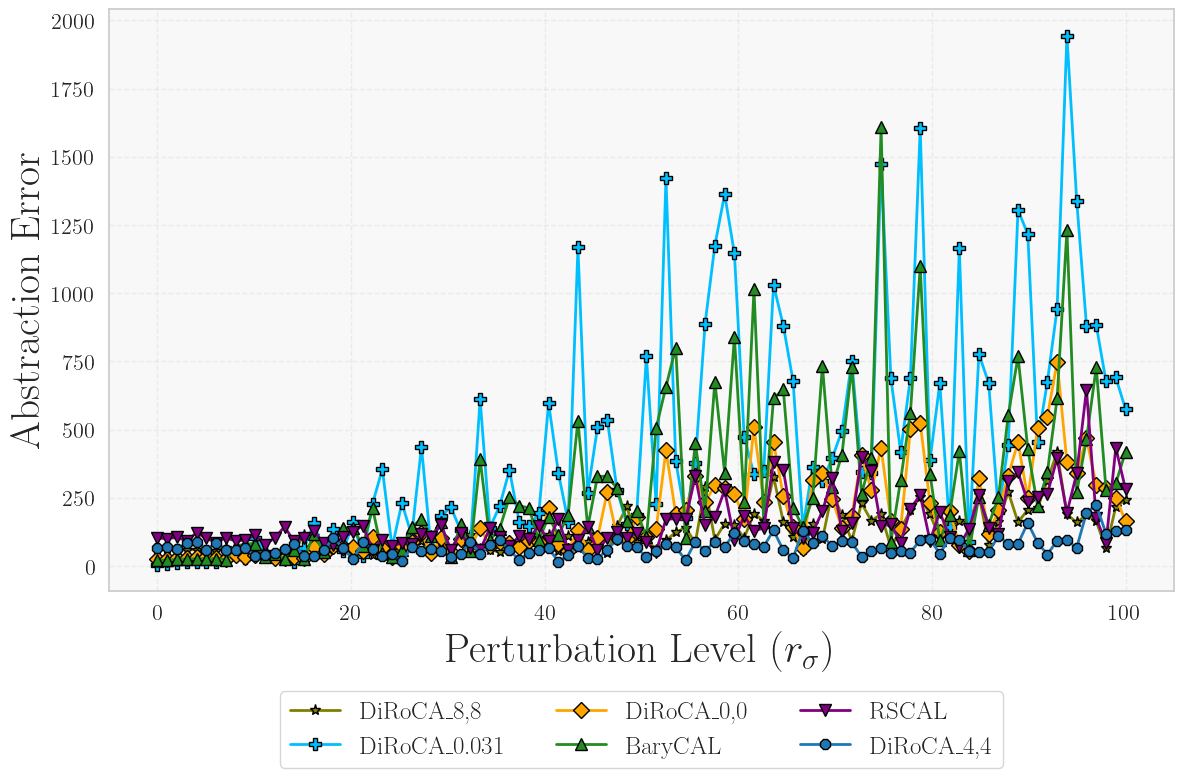

In [125]:
import numpy as np
import matplotlib.pyplot as plt

# Define the r_sigma values to sweep over
sigma_values = np.linspace(0, 100, 100)
methods_to_track = list(T_results.keys())
methods_to_track = ['T_8', 'T_0.031', 'T_0.00', 'T_b', 'T_s', 'T_4']
error_evolution = {method: [] for method in methods_to_track}

for r_sigma in sigma_values:
    print(f"Testing with r_sigma = {r_sigma}")
    # Generate shifted Gaussian families for this sigma
    shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 1, r_mu=0.0, r_sigma=r_sigma, coverage='uniform', seed=None)
    shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 1, r_mu=0.0, r_sigma=r_sigma, coverage='uniform', seed=None)

    # Initialize results for this sigma
    results = {method: [] for method in methods_to_track}

    for shift_L, shift_H in zip(shift_family_L, shift_family_H):
        noise_muL, noise_SigmaL = shift_L
        noise_muH, noise_SigmaH = shift_H
        noise_muL = noise_muL.numpy() if hasattr(noise_muL, 'numpy') else noise_muL
        noise_muH = noise_muH.numpy() if hasattr(noise_muH, 'numpy') else noise_muH
        noise_SigmaL = noise_SigmaL.numpy() if hasattr(noise_SigmaL, 'numpy') else noise_SigmaL
        noise_SigmaH = noise_SigmaH.numpy() if hasattr(noise_SigmaH, 'numpy') else noise_SigmaH

        for name in methods_to_track:
            res = T_results[name]
            T = res['T_matrix']
            wass_total = 0
            for iota in Ill:
                L_i = LLmodels[iota].F
                V_i = T @ L_i
                H_i = HLmodels[omega[iota]].F
                muV = V_i @ noise_muL
                sigmaV = V_i @ noise_SigmaL @ V_i.T
                muH = H_i @ noise_muH
                sigmaH = H_i @ noise_SigmaH @ H_i.T
                wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                wass_total += wass_dist
            results[name].append(wass_total / len(Ill))

    # Store mean squared error for each method for this sigma
    for method in methods_to_track:
        error_evolution[method].append(np.mean(results[method])**2)
# # Plotting
# fig, ax = plt.subplots(figsize=(12, 8))
# method_labels = {
#     'T_8':      ('DiRoCA_8,8',    '#808000', '*'),   # olive
#     'T_0.031':  ('DiRoCA_0.031',  '#00bfff', 'P'),   # deep sky blue
#     'T_0.00':   ('DiRoCA_0,0',    '#ffa500', 'D'),   # orange
#     'T_b':      ('BaryCAL',       '#228B22', '^'),   # forest green
#     'T_s':      ('RSCAL',         '#800080', 'v'),   # purple
#     'T_2':      ('DiRoCA_2,2',    '#e377c2', 'h'),   # pink
#     'T_1':      ('DiRoCA_1,1',    '#8B4513', 'p'),   # saddle brown
#     'T_4':      ('DiRoCA_4,4',    '#1f77b4', '8'),   # blue
# }
# for method, errors in error_evolution.items():
#     style = method_labels.get(method, (method, 'black', 'o'))
#     ax.plot(sigma_values, errors, marker=style[2], label=style[0], color=style[1],
#             linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1)
# ax.set_xlabel('Perturbation Level ($r_\\sigma$)', fontsize=30)
# ax.set_ylabel('Abstraction Error', fontsize=30)
# ax.grid(True, linestyle='--', alpha=0.3)
# ax.tick_params(axis='both', labelsize=16)
# ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=True, fontsize=18)
# ax.set_facecolor('#f8f8f8')
# plt.tight_layout()
# plt.show()

In [126]:
print(f"\n{'Method':<15} {'Mean ± 1.96*Std':<35}")
print("="*40)
method_stats = []
for method in methods_to_track:
    mean = np.mean(results[method])
    std = np.std(results[method])
    method_stats.append((method, mean, std))
# Sort by mean, descending (worst to best)
method_stats.sort(key=lambda x: x[1], reverse=True)
for method, mean, std in method_stats:
    print(f"{method:<15} {mean:8.4f} ± {1.96*std:<8.4f}")
print("="*40)


Method          Mean ± 1.96*Std                    
T_0.031          23.9703 ± 0.0000  
T_b              20.4863 ± 0.0000  
T_s              16.7554 ± 0.0000  
T_8              15.5577 ± 0.0000  
T_0.00           12.7886 ± 0.0000  
T_4              11.5347 ± 0.0000  


In [199]:
import numpy as np
import matplotlib.pyplot as plt

# Define the r_sigma values to sweep over
sigma_values = np.linspace(0, 10, 100)
methods_to_track = list(T_results.keys())

# Storage for plotting and for mean/CI across all sigmas
error_evolution = {method: [] for method in methods_to_track}
mean_across_sigmas = {method: [] for method in methods_to_track}
ci_across_sigmas = {method: [] for method in methods_to_track}

for r_sigma in sigma_values:
    #print(f"Testing with r_sigma = {r_sigma}")
    # Generate shifted Gaussian families for this sigma
    shift_family_L = mut.generate_shifted_gaussian_family(
        mu_worst_L, Sigma_worst_L, 1, r_mu=0, r_sigma=r_sigma, coverage='rand', seed=None)
    shift_family_H = mut.generate_shifted_gaussian_family(
        mu_worst_H, Sigma_worst_H, 1, r_mu=0, r_sigma=r_sigma, coverage='rand', seed=None)

    # Initialize results for this sigma
    results = {method: [] for method in methods_to_track}

    for shift_L, shift_H in zip(shift_family_L, shift_family_H):
        noise_muL, noise_SigmaL = shift_L
        noise_muH, noise_SigmaH = shift_H
        noise_muL = noise_muL.numpy() if hasattr(noise_muL, 'numpy') else noise_muL
        noise_muH = noise_muH.numpy() if hasattr(noise_muH, 'numpy') else noise_muH
        noise_SigmaL = noise_SigmaL.numpy() if hasattr(noise_SigmaL, 'numpy') else noise_SigmaL
        noise_SigmaH = noise_SigmaH.numpy() if hasattr(noise_SigmaH, 'numpy') else noise_SigmaH

        for name in methods_to_track:
            res = T_results[name]
            T = res['T_matrix']
            wass_total = 0
            for iota in Ill:
                L_i = LLmodels[iota].F
                V_i = T @ L_i
                H_i = HLmodels[omega[iota]].F
                muV = V_i @ noise_muL
                sigmaV = V_i @ noise_SigmaL @ V_i.T
                muH = H_i @ noise_muH
                sigmaH = H_i @ noise_SigmaH @ H_i.T
                wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                wass_total += wass_dist
            results[name].append(wass_total / len(Ill))

    # Store mean and CI for each method for this sigma
    for method in methods_to_track:
        mean = np.mean(results[method])
        std = np.std(results[method])
        ci = std/10
        error_evolution[method].append(mean)
        mean_across_sigmas[method].append(mean)
        ci_across_sigmas[method].append(ci)

# Print mean and CI across all sigmas for each method
print(f"\n{'Method':<15} {'Mean across sigmas ± 1.96*Std':<35}")
print("="*50)
method_stats = []
for method in methods_to_track:
    mean_over_sigmas = np.mean(mean_across_sigmas[method])
    std_over_sigmas = np.std(mean_across_sigmas[method])
    ci_over_sigmas = std_over_sigmas
    method_stats.append((method, mean_over_sigmas, ci_over_sigmas))
# Sort by mean, descending (worst to best)
method_stats.sort(key=lambda x: x[1], reverse=True)
for method, mean, ci in method_stats:
    print(f"{method:<15} {mean:8.4f} ± {ci:<8.4f}")
print("="*50)


Method          Mean across sigmas ± 1.96*Std      
T_0.031          12.8922 ± 1.7925  
T_2               8.8674 ± 0.9136  
T_1               7.3907 ± 1.0875  
T_b               7.2307 ± 1.1292  
T_s               5.9494 ± 0.3413  
T_4               5.6337 ± 0.2157  
T_0.00            5.4516 ± 0.9418  
T_8               4.5632 ± 0.4943  


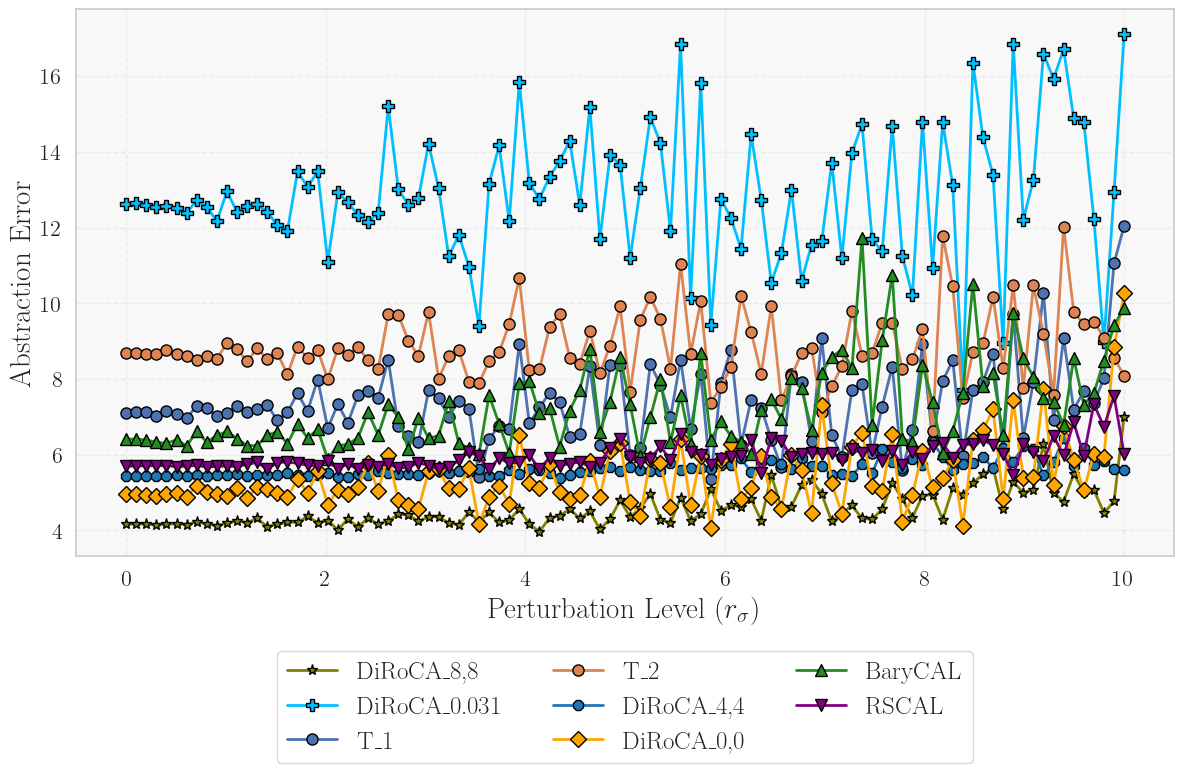

In [200]:

method_labels = {
    'T_8':      ('DiRoCA_8,8',    '#808000', '*'),   # olive
    'T_0.031':  ('DiRoCA_0.031',  '#00bfff', 'P'),   # deep sky blue
    'T_0.00':   ('DiRoCA_0,0',    '#ffa500', 'D'),   # orange
    'T_b':      ('BaryCAL',       '#228B22', '^'),   # forest green
    'T_s':      ('RSCAL',         '#800080', 'v'),   # purple
    'T_4':      ('DiRoCA_4,4',    '#1f77b4', '8'),   # blue
}

fig, ax = plt.subplots(figsize=(12, 8))
for method in methods_to_track:
    style = method_labels.get(method, (method, None, 'o'))
    ax.plot(
        sigma_values, error_evolution[method],
        marker=style[2], label=style[0], color=style[1],
        linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1
    )

ax.set_xlabel('Perturbation Level ($r_\\sigma$)', fontsize=21)
ax.set_ylabel('Abstraction Error', fontsize=21)
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=True, fontsize=18)
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.show()

In [77]:
for r_sigma in np.linspace(0, 10, 10):
for center in ['worst']:
    for coverage_type in ['uniform']:
        print(f"Center: {center}, Coverage: {coverage_type}")
        if center == 'worst':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
        elif center == 'hat':
            shift_family_L = mut.generate_shifted_gaussian_family(mu_U_ll_hat, Sigma_U_ll_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)
            shift_family_H = mut.generate_shifted_gaussian_family(mu_U_hl_hat, Sigma_U_hl_hat, 100, r_mu=0.0, r_sigma=100.0, coverage=coverage_type, seed=None)

        results = {
            sample_form: {  # This is correct - using the variable
                'wass': {method: [] for method in T_results.keys()}
            } for sample_form in sample_forms
        }

        for shift_L, shift_H in zip(shift_family_L, shift_family_H):
            for sample_form in sample_forms:
            
                # Use the shifted means and covariances directly
                noise_muL, noise_SigmaL = shift_L
                noise_muH, noise_SigmaH = shift_H
                
                
                # Convert to numpy if they're tensors
                noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
                noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
                noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
                noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

                for name, res in T_results.items():
                    T = res['T_matrix']
                    wass_total = 0
                    for iota in Ill:
                        L_i = LLmodels[iota].F
                        V_i = T @ L_i
                        H_i = HLmodels[omega[iota]].F
                        
                        muV    = V_i @ noise_muL
                        sigmaV = V_i @ noise_SigmaL @ V_i.T
                        muH    = H_i @ noise_muH
                        sigmaH = H_i @ noise_SigmaH @ H_i.T

                        # Compute Wasserstein metric
                        wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                        wass_total += wass_dist

                    # Store results
                    results[sample_form]['wass'][name].append(wass_total / len(Ill))

        print("\n" + "="*100)
        print(f"{'Method':<15} {'Wasserstein (mean ± CI)':<35}")
        print("="*100)

        for sample_form in sample_forms:
            print(f"\nSample form: {sample_form}")
            print("-"*100)
            
            # Create a list of (method, mean, std) tuples and sort by mean (worst to best)
            method_stats = []
            for method in T_results.keys():
                wass_mean = np.mean(results[sample_form]['wass'][method])
                wass_std = np.std(results[sample_form]['wass'][method])
                method_stats.append((method, wass_mean, wass_std))
            
            # Sort by mean value (descending order - worst to best)
            method_stats.sort(key=lambda x: x[1], reverse=True)
            
            # Print sorted results
            for method, wass_mean, wass_std in method_stats:
                print(f"{method:<15} "
                    f"{wass_mean:>8.4f} ± {1.96*wass_std:<8.4f}")

        print("="*100)

        # Find best methods for Wasserstein metric
        for sample_form in sample_forms:
            print(f"\nBest methods for {sample_form} sampling:")
            
            # For Wasserstein
            wass_means = {method: np.mean(results[sample_form]['wass'][method])
                        for method in T_results.keys()}
            best_wass = min(wass_means.items(), key=lambda x: x[1])
            
            print(f"Best Wasserstein: {best_wass[0]} ({best_wass[1]:.4f})")
        print( )

['T_8', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_0.00', 'T_b', 'T_s']

Testing with r_mu = 0.0, r_sigma = 0.0
Testing with r_mu = 11.11111111111111, r_sigma = 0.0
Testing with r_mu = 22.22222222222222, r_sigma = 0.0
Testing with r_mu = 33.33333333333333, r_sigma = 0.0
Testing with r_mu = 44.44444444444444, r_sigma = 0.0
Testing with r_mu = 55.55555555555556, r_sigma = 0.0
Testing with r_mu = 66.66666666666666, r_sigma = 0.0
Testing with r_mu = 77.77777777777777, r_sigma = 0.0
Testing with r_mu = 88.88888888888889, r_sigma = 0.0
Testing with r_mu = 100.0, r_sigma = 0.0


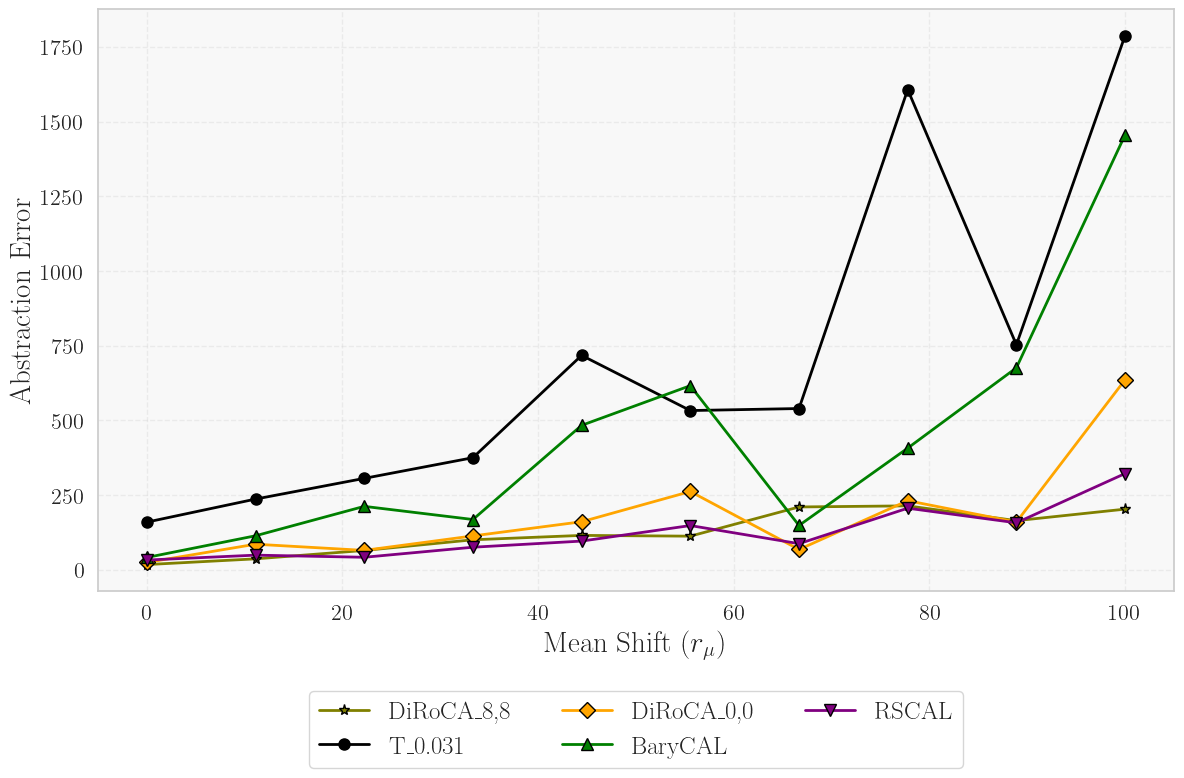

In [87]:
import numpy as np
import matplotlib.pyplot as plt

# Define the values to test for r_mu (mean shift), keeping r_sigma fixed
mu_values = np.linspace(0, 100, 10)  # Adjust range as needed
r_sigma_fixed = 0.0

# Methods to track (adapt as needed)
methods_to_track = ['T_8', 'T_0.031', 'T_0.00', 'T_b', 'T_s']
error_evolution = {method: [] for method in methods_to_track}

for r_mu in mu_values:
    print(f"Testing with r_mu = {r_mu}, r_sigma = {r_sigma_fixed}")
    # Generate shifted Gaussian families with varying mean
    shift_family_L = mut.generate_shifted_gaussian_family(mu_worst_L, Sigma_worst_L, 2, r_mu=r_sigma_fixed, r_sigma=r_mu, coverage='uniform', seed=None)
    shift_family_H = mut.generate_shifted_gaussian_family(mu_worst_H, Sigma_worst_H, 2, r_mu=r_sigma_fixed, r_sigma=r_mu, coverage='uniform', seed=None)

    # Compute errors as in your loop
    results = {method: [] for method in methods_to_track}
    for shift_L, shift_H in zip(shift_family_L, shift_family_H):
        noise_muL, noise_SigmaL = shift_L
        noise_muH, noise_SigmaH = shift_H
        noise_muL = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
        noise_muH = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
        noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
        noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

        for name in methods_to_track:
            res = T_results[name]
            T = res['T_matrix']
            wass_total = 0
            for iota in Ill:
                L_i = LLmodels[iota].F
                V_i = T @ L_i
                H_i = HLmodels[omega[iota]].F
                muV = V_i @ noise_muL
                sigmaV = V_i @ noise_SigmaL @ V_i.T
                muH = H_i @ noise_muH
                sigmaH = H_i @ noise_SigmaH @ H_i.T
                wass_dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                wass_total += wass_dist
            results[name].append(wass_total / len(Ill))
    # Store mean squared error for each method
    for method in methods_to_track:
        error_evolution[method].append(np.mean(results[method])**2)

# Plotting (adapt legend/colors as in your empirical plot)
fig, ax = plt.subplots(figsize=(12, 8))
method_labels = {
    'T_pa': ('AbstLin_p', 'red', 'o'),
    'T_na': ('AbstLin_n', 'blue', 's'),
    'T_b': ('BaryCAL', 'green', '^'),
    'T_s': ('RSCAL', 'purple', 'v'),
    'T_0.00': ('DiRoCA_0,0', 'orange', 'D'),
    'T_8': ('DiRoCA_8,8', 'olive', '*'),
    # Add more if needed
}
for method, errors in error_evolution.items():
    style = method_labels.get(method, (method, 'black', 'o'))
    ax.plot(mu_values, errors, marker=style[2], label=style[0], color=style[1],
            linewidth=2, markersize=8, markeredgecolor='black', markeredgewidth=1)
ax.set_xlabel('Mean Shift ($r_\\mu$)', fontsize=21)
ax.set_ylabel('Abstraction Error', fontsize=21)
ax.grid(True, linestyle='--', alpha=0.3)
ax.tick_params(axis='both', labelsize=16)
ax.legend(bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=3, frameon=True, fontsize=18)
ax.set_facecolor('#f8f8f8')
plt.tight_layout()
plt.show()

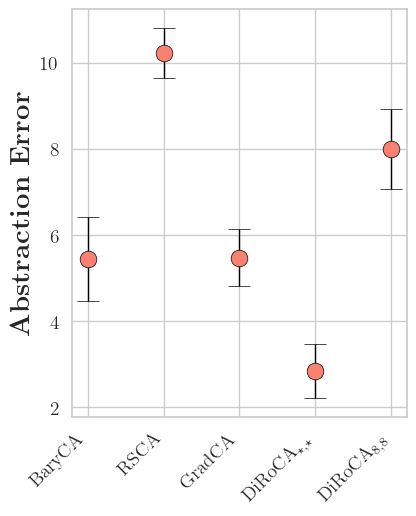

In [74]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams

# Enable LaTeX font rendering
rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})

# Methods
methods = [
    "BaryCA", "RSCA", "GradCA", "DiRoCA$_{\\star, \\star}$", "DiRoCA$_{8,8}$"
]

# LiLUCAS 0-shift: mean and std
means = [5.44, 10.23, 5.48, 2.84, 8.00]
stds =  [3.09, 1.84, 2.07, 1.97, 2.90]
errors = [s /3.16 for s in stds]  # scaled for visual clarity

# X positions
x_pos = np.arange(len(methods))

# Plot
plt.figure(figsize=(4, 5))
plt.errorbar(
    x_pos, means, yerr=errors,
    fmt='o', capsize=8, elinewidth=1,
    markersize=12, markerfacecolor='salmon', markeredgecolor='black', markeredgewidth=.5,
    ecolor='black'
)


# Style
plt.xticks(x_pos, methods, rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(r'\textbf{Abstraction Error}', fontsize=20)

# Finalize
plt.tight_layout(pad=0.1)
plt.show()

## F-contamination

In [173]:
def contaminate_structural_matrix(M, contamination_fraction, contamination_type, num_segments=10, seed=None):
   """
   Contaminates a linear transformation matrix M to break its strict linearity.
  
   Args:
       M (np.ndarray): Original linear transformation matrix (n x m).
       contamination_fraction (float): Magnitude of contamination (e.g., between 0.05 and 1.0).
       contamination_type (str): Type of contamination to apply. Options are:
                                 'multiplicative', 'nonlinear', or 'piecewise'.
       num_segments (int): Number of segments for piecewise linear contamination (default: 3).
       seed (int, optional): Random seed for reproducibility.
      
   Returns:
       np.ndarray: The contaminated matrix.
   """
   rng = np.random.default_rng(seed)
   M_cont = M.copy() 
   n, m = M.shape


   if contamination_type == "multiplicative":
       # Apply element-wise multiplicative noise (preserving zeros below the main diagonal)
       # Only perturb the upper-triangular part.
       noise = rng.uniform(low=1.0 - contamination_fraction, high=1.0 + contamination_fraction, size=M.shape)
       # Create a mask for the upper triangular (including diagonal)
       mask = np.triu(np.ones_like(M))
       M_cont = M * (1 - mask + mask * noise)
  
   elif contamination_type == "nonlinear":
       # Apply a nonlinear function to L: for instance, add a sine-based perturbation.
       M_cont = M + contamination_fraction * np.sin(M)
  
   elif contamination_type == "piecewise":
       # Contaminate each row with a piecewise linear function.
       def piecewise_contaminate_row(row, cont_frac, segments, rng):
           n_elem = len(row)
           # Choose random breakpoints among indices
           if segments < 2:
               return row  # nothing to do
           breakpoints = np.sort(rng.integers(low=1, high=n_elem, size=segments - 1))
           breakpoints = np.concatenate(([0], breakpoints, [n_elem]))
           contaminated_row = np.empty_like(row)
           # For each segment, assign a random multiplicative factor.
           for j in range(len(breakpoints) - 1):
               start = breakpoints[j]
               end = breakpoints[j+1]
               factor = 1.0 + rng.uniform(low=-cont_frac, high=cont_frac)
               contaminated_row[start:end] = row[start:end] * factor
           return contaminated_row
      
       # Apply the piecewise contamination row-by-row.
       for i in range(n):
           M_cont[i, :] = piecewise_contaminate_row(M[i, :], contamination_fraction, num_segments, rng)
  
   else:
       raise ValueError("Unknown contamination type. Choose among 'multiplicative', 'nonlinear', or 'piecewise'.")
  
   return M_cont


In [174]:
def plot_contamination_results(plot_results, contamination_levels, cont_type, methods_to_plot=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        plot_results: Dictionary containing means and stds for each method
        contamination_levels: Array of contamination levels tested
        cont_type: Type of contamination applied
        methods_to_plot: List of method names to plot. If None, plots all methods
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: plot_results[method] 
                      for method in methods_to_plot 
                      if method in plot_results}
    
    # Define base method styles
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Add styles for trained T matrices using different markers and blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
    markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        method_styles[method_name] = {
            'color': blues[i],
            'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
            'marker': markers[i]
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(contamination_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(contamination_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Contamination Level', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    plt.title(f'Abstraction Error vs Contamination Level\n({cont_type} contamination)',
             fontsize=16, pad=20)
    
    plt.xticks(contamination_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print ordered results for each contamination level
    print("\nOrdered results at each contamination level (worst to best):")
    for i, cont_frac in enumerate(contamination_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        # Sort by error value in descending order (worst to best)
        sorted_methods = sorted(errors.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nContamination level {cont_frac:.2f}:")
        print("-" * 40)
        for method, error in sorted_methods:
            print(f"{method:8s}: {error:.4f}")
        print("-" * 40)

100%|██████████| 5/5 [00:08<00:00,  1.64s/it]



Ordered results at each contamination level (worst to best):

Contamination level 0.00:
----------------------------------------
T_4     : 8.6578
T_8     : 8.0031
T_0.00  : 5.4773
T_b     : 5.4416
T_2     : 5.3168
T_1     : 4.9972
T_0.031 : 2.8445
----------------------------------------

Contamination level 2.50:
----------------------------------------
T_b     : 18.4816
T_0.031 : 17.7404
T_0.00  : 16.3742
T_1     : 16.3093
T_2     : 16.2725
T_8     : 15.9953
T_4     : 15.1228
----------------------------------------

Contamination level 5.00:
----------------------------------------
T_b     : 34.0587
T_0.031 : 32.7455
T_2     : 30.1329
T_8     : 30.0373
T_0.00  : 29.3977
T_1     : 29.3208
T_4     : 27.6947
----------------------------------------

Contamination level 7.50:
----------------------------------------
T_0.031 : 50.1481
T_b     : 49.0114
T_8     : 45.1761
T_2     : 43.1168
T_1     : 42.2464
T_0.00  : 39.3933
T_4     : 38.9650
----------------------------------------

Cont

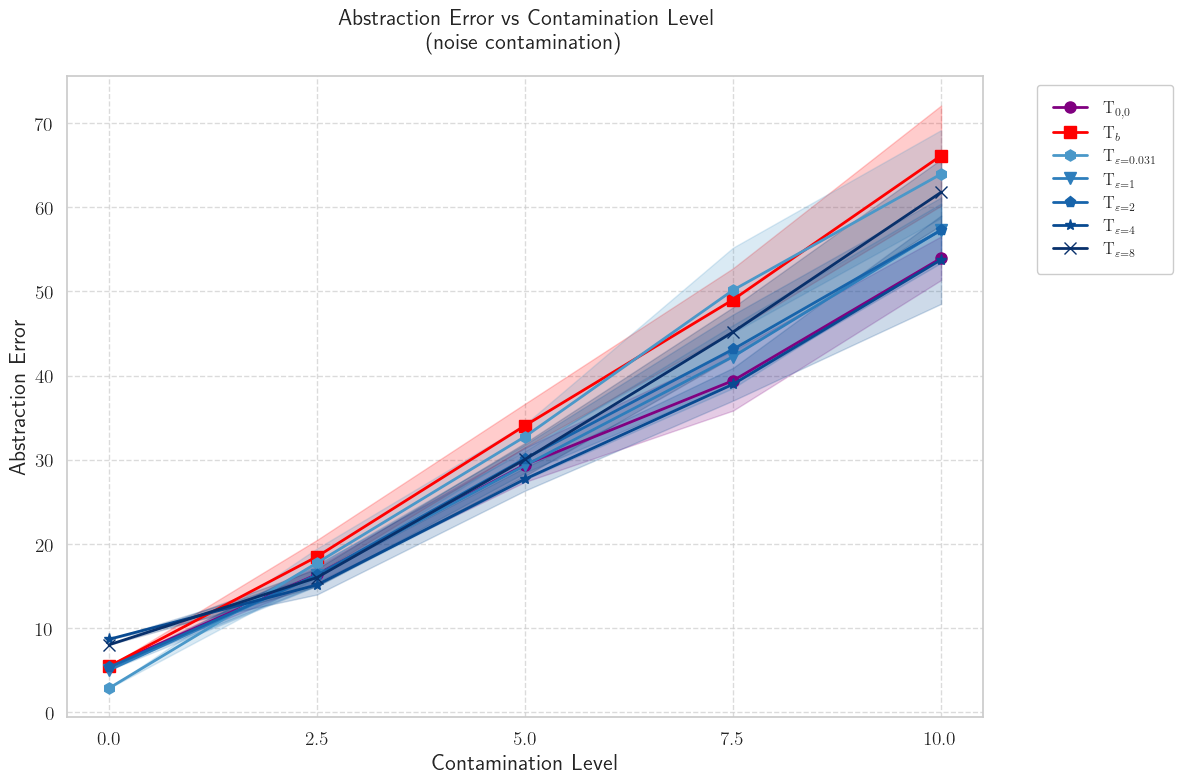

In [69]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 10.0, 5)  # [0.1, 0.2, 0.3, 0.4, 0.5]
cont_type = 'piecewise'

# Store results for plotting
plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


# Run experiment for each contamination level
for cont_frac in tqdm(contamination_levels):
   #print(f"\nTesting contamination fraction: {cont_frac:.2f}")
   abstraction_error = {name: [] for name in T_results.keys()}
  
   for _ in range(10):
       noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
       noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
      
       noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
       noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
       noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
       noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH


       for name, res in T_results.items():
           T = res['T_matrix']
           total = 0
           for iota in Ill:
               L_i = LLmodels[iota].F
               L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
               V_i = T @ L_i
               H_i = HLmodels[omega[iota]].F
               H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
              
               muV    = V_i @ noise_muL
               sigmaV = V_i @ noise_SigmaL @ V_i.T
               muH    = H_i @ noise_muH
               sigmaH = H_i @ noise_SigmaH @ H_i.T


               dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
               total += dist


           iter_avg = total / len(Ill)
           abstraction_error[name].append(iter_avg)


   # Store results for this contamination level
   for method in T_results.keys():
       mean_e = np.mean(abstraction_error[method])
       std_e = np.std(abstraction_error[method])
       plot_results[method]['means'].append(mean_e)
       plot_results[method]['stds'].append(std_e)


# Example: plot only three methods
methods_to_plot = ['T_0.00', 'T_b', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
plot_contamination_results(plot_results, contamination_levels, "noise",
                         methods_to_plot=methods_to_plot)

In [177]:
# Define contamination levels to test
contamination_levels = np.linspace(0.0, 1.0, 100)  # [0.1, 0.2, 0.3, 0.4, 0.5]
for cont_type in ['piecewise']:
    print(f"Contamination type: {cont_type}")
    # Store results for plotting
    plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


    # Run experiment for each contamination level
    for cont_frac in tqdm(contamination_levels):
    #print(f"\nTesting contamination fraction: {cont_frac:.2f}")
        abstraction_error = {name: [] for name in T_results.keys()}
    
        for _ in range(1):
            noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
            noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
            
            noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
            noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
            noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
            noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH


            for name, res in T_results.items():
                T = res['T_matrix']
                total = 0
                for iota in Ill:
                    L_i = LLmodels[iota].F
                    L_i = contaminate_structural_matrix(L_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    V_i = T @ L_i
                    H_i = HLmodels[omega[iota]].F
                    H_i = contaminate_structural_matrix(H_i, contamination_fraction=cont_frac, contamination_type=cont_type)
                    
                    muV    = V_i @ noise_muL
                    sigmaV = V_i @ noise_SigmaL @ V_i.T
                    muH    = H_i @ noise_muH
                    sigmaH = H_i @ noise_SigmaH @ H_i.T


                    dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
                    # dim = muV.shape[0]  # number of dimensions
                    # dist = dist / np.sqrt(dim)

                    total += dist


                iter_avg = total / len(Ill)
                abstraction_error[name].append(iter_avg)


        # Store results for this contamination level
        for method in T_results.keys():
            mean_e = np.mean(abstraction_error[method])
            std_e = np.std(abstraction_error[method])
            plot_results[method]['means'].append(mean_e)
            plot_results[method]['stds'].append(std_e)

    # Compute averages across all contamination levels for each method
    method_averages = {}

    for method in T_results.keys():
        # Get all means across contamination levels
        all_means = plot_results[method]['means']
        # Compute the mean and std across all contamination levels
        overall_mean = np.mean(all_means)
        overall_std = np.std(all_means)
        method_averages[method] = (overall_mean, overall_std)

    # Sort methods by average (worst to best)
    sorted_methods = sorted(method_averages.items(), key=lambda x: x[1][0], reverse=True)

    # Print results
    print("\n" + "="*100)
    print("AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)")
    print("="*100)
    print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
    print("-"*100)

    for method, (mean, std) in sorted_methods:
        ci = std
        print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

    print("="*100)


Contamination type: piecewise


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 27.27it/s]


AVERAGE WASSERSTEIN DISTANCE ACROSS ALL CONTAMINATION LEVELS (0.0 to 1.0)
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_s               2.1034 ± 0.3601  
T_4               2.0701 ± 0.3338  
T_8               2.0246 ± 0.3388  
T_2               1.9364 ± 0.3124  
T_1               1.6749 ± 0.3317  
T_0.00            0.9560 ± 0.5080  
T_b               0.8806 ± 0.4905  
T_0.031           0.8643 ± 0.4752  


## ω-contamination

In [178]:
def contaminate_omega_map(original_omega, num_misalignments):
    """
    Randomly corrupt a subset of entries in the ω map to simulate mapping misspecification.
    
    Args:
        original_omega (dict): Original intervention mapping.
            For example: {None: None, iota1: H_i1, iota2: H_i1, iota3: H_i2, ...}
        num_misalignments (int): Desired number of misaligned mappings.
        
    Returns:
        dict: A new ω mapping with up to num_misalignments entries altered.
    """
    # Exclude keys or values that are None if desired.
    omega_keys = [k for k in original_omega.keys() if k is not None]
    omega_vals = [original_omega[k] for k in omega_keys if original_omega[k] is not None]
    
    # Start with a copy of the original mapping.
    contaminated_omega = original_omega.copy()
    
    # Bound the number of misalignments by the number of eligible keys.
    num_to_corrupt = min(num_misalignments, len(omega_keys))
    
    # Randomly select keys to corrupt.
    to_corrupt = random.sample(omega_keys, k=num_to_corrupt)
    
    # Create a random permutation of available targets (ensuring change)
    # Use the set of targets from eligible keys.
    all_targets = list(set(omega_vals))
    
    for key in to_corrupt:
        original_target = original_omega[key]
        # Only corrupt if there's an alternative available.
        available_targets = [t for t in all_targets if t != original_target]
        if available_targets:
            new_target = random.choice(available_targets)
            contaminated_omega[key] = new_target
            
    return contaminated_omega

In [179]:
# Define contamination levels to test
misalignment_levels = range(0, len(Ill))

# Store results for plotting
omega_plot_results = {method: {'means': [], 'stds': []} for method in T_results.keys()}


# Run experiment for each contamination level
for num_mis in tqdm(misalignment_levels):
   abstraction_error = {name: [] for name in T_results.keys()}
  
   for _ in range(1):
    noise_muL, noise_SigmaL = mu_U_ll_hat, Sigma_U_ll_hat
    noise_muH, noise_SigmaH = mu_U_hl_hat, Sigma_U_hl_hat
    
    noise_muL    = noise_muL.numpy() if torch.is_tensor(noise_muL) else noise_muL
    noise_muH    = noise_muH.numpy() if torch.is_tensor(noise_muH) else noise_muH
    noise_SigmaL = noise_SigmaL.numpy() if torch.is_tensor(noise_SigmaL) else noise_SigmaL
    noise_SigmaH = noise_SigmaH.numpy() if torch.is_tensor(noise_SigmaH) else noise_SigmaH

    omega_cont = contaminate_omega_map(omega, num_mis)


    for name, res in T_results.items():
        T = res['T_matrix']
        total = 0
        for iota in Ill:
            L_i = LLmodels[iota].F
            V_i = T @ L_i
            H_i = HLmodels[omega_cont[iota]].F
            
            muV    = V_i @ noise_muL
            sigmaV = V_i @ noise_SigmaL @ V_i.T
            muH    = H_i @ noise_muH
            sigmaH = H_i @ noise_SigmaH @ H_i.T


            dist = np.sqrt(compute_wasserstein(muV, sigmaV, muH, sigmaH))
            total += dist


        iter_avg = total / len(Ill)
        abstraction_error[name].append(iter_avg)


   # Store results for this contamination level
   for method in T_results.keys():
       mean_e = np.mean(abstraction_error[method])
       std_e = np.std(abstraction_error[method])
       omega_plot_results[method]['means'].append(mean_e)
       omega_plot_results[method]['stds'].append(std_e)



100%|██████████| 6/6 [00:00<00:00, 66.20it/s]


In [180]:
def plot_omega_contamination_results(omega_plot_results, misalignment_levels, methods_to_plot=None):
    """
    Plot the results of contamination analysis for selected methods.
    
    Args:
        omega_plot_results: Dictionary containing means and stds for each method
        misalignment_levels: Array of misalignment levels tested
        methods_to_plot: List of method names to plot. If None, plots all methods
    """
    # If no methods specified, use all methods
    if methods_to_plot is None:
        methods_to_plot = list(omega_plot_results.keys())
    
    # Filter results to only include specified methods
    filtered_results = {method: omega_plot_results[method] 
                      for method in methods_to_plot 
                      if method in omega_plot_results}
    
    # Define base method styles
    method_styles = {
        'T_0.00': {'color': 'purple', 'label': r'$\mathrm{T}_{0,0}$', 'marker': 'o'},
        'T_b': {'color': 'red', 'label': r'$\mathrm{T}_{b}$', 'marker': 's'},
        'T_s': {'color': 'green', 'label': r'$\mathrm{T}_{s}$', 'marker': '^'},
        'T_ba': {'color': 'orange', 'label': r'$\mathrm{T}_{ba}$', 'marker': 'D'}
    }
    
    # Add styles for trained T matrices using different markers and blues
    blues = plt.cm.Blues(np.linspace(0.6, 1, 5))  # 5 shades of blue
    markers = ['h', 'v', 'p', '*', 'x']  # Different marker shapes
    for i, eps in enumerate(['0.031', '1', '2', '4', '8']):
        method_name = f'T_{eps}'
        method_styles[method_name] = {
            'color': blues[i],
            'label': f'$\\mathrm{{T}}_{{\\varepsilon={eps}}}$',
            'marker': markers[i]
        }
    
    # Set style
    sns.set_theme(style="whitegrid")
    
    # Create figure
    plt.figure(figsize=(12, 8))
    
    # Plot for each selected method
    for method_name in filtered_results.keys():
        style = method_styles.get(method_name, {
            'color': 'black',
            'marker': 'o',
            'label': method_name
        })
        means = filtered_results[method_name]['means']
        stds = filtered_results[method_name]['stds']
        
        # Plot mean line with markers
        plt.plot(misalignment_levels, means,
                f"{style['marker']}-",
                color=style['color'],
                label=style['label'],
                markersize=8,
                linewidth=2)
        
        # Add error bands
        plt.fill_between(misalignment_levels,
                        np.array(means) - np.array(stds),
                        np.array(means) + np.array(stds),
                        color=style['color'],
                        alpha=0.2)
    
    # Customize plot
    plt.xlabel('Number of Misalignments', fontsize=16)
    plt.ylabel('Abstraction Error', fontsize=16)
    plt.title(f'Abstraction Error vs Number of Misalignments',
             fontsize=16, pad=20)
    
    plt.xticks(misalignment_levels, fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add legend
    plt.legend(prop={'size': 12},
              frameon=True,
              framealpha=1,
              borderpad=1,
              handletextpad=1,
              handlelength=2,
              bbox_to_anchor=(1.05, 1),
              loc='upper left')
    
    # Add grid and adjust layout
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # Print ordered results for each misalignment level
    print("\nOrdered results at each misalignment level (worst to best):")
    for i, num_mis in enumerate(misalignment_levels):
        errors = {method: filtered_results[method]['means'][i] for method in filtered_results.keys()}
        # Sort by error value in descending order (worst to best)
        sorted_methods = sorted(errors.items(), key=lambda x: x[1], reverse=True)
        
        print(f"\nNumber of misalignments: {num_mis}")
        print("-" * 40)
        for method, error in sorted_methods:
            print(f"{method:8s}: {error:.4f}")
        print("-" * 40)

# # Example: plot only three methods
# methods_to_plot = ['T_0.00', 'T_b', 'T_0.031', 'T_1', 'T_2', 'T_4', 'T_8']
# plot_omega_contamination_results(omega_plot_results, misalignment_levels, 
#                                methods_to_plot=methods_to_plot)

In [181]:
# Compute and print the overall averages across all misalignment levels
print("\n" + "="*100)
print("AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS")
print("="*100)
print(f"{'Method':<15} {'Mean ± CI (95%)':<35}")
print("-"*100)

# Compute averages for each method
method_averages = []
for method in T_results.keys():
    # Get all means across misalignment levels
    all_means = omega_plot_results[method]['means']
    # Compute overall mean and std
    overall_mean = np.mean(all_means)
    overall_std = np.std(all_means)
    method_averages.append((method, overall_mean, overall_std))

# Sort methods by mean (worst to best)
method_averages.sort(key=lambda x: x[1], reverse=True)

# Print sorted averages
for method, mean, std in method_averages:
    ci = std
    print(f"{method:<15} {mean:>8.4f} ± {ci:<8.4f}")

print("="*100)


AVERAGE ERROR ACROSS ALL OMEGA MISALIGNMENTS
Method          Mean ± CI (95%)                    
----------------------------------------------------------------------------------------------------
T_s               2.0500 ± 0.0000  
T_8               1.8717 ± 0.0000  
T_4               1.8717 ± 0.0000  
T_2               1.7095 ± 0.0000  
T_1               1.4477 ± 0.0000  
T_0.00            0.3503 ± 0.0000  
T_b               0.1791 ± 0.0000  
T_0.031           0.1428 ± 0.0000  


INFO:matplotlib.mathtext:Substituting symbol F from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol F from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol F from STIXNonUnicode
INFO:matplotlib.mathtext:Substituting symbol F from STIXNonUnicode


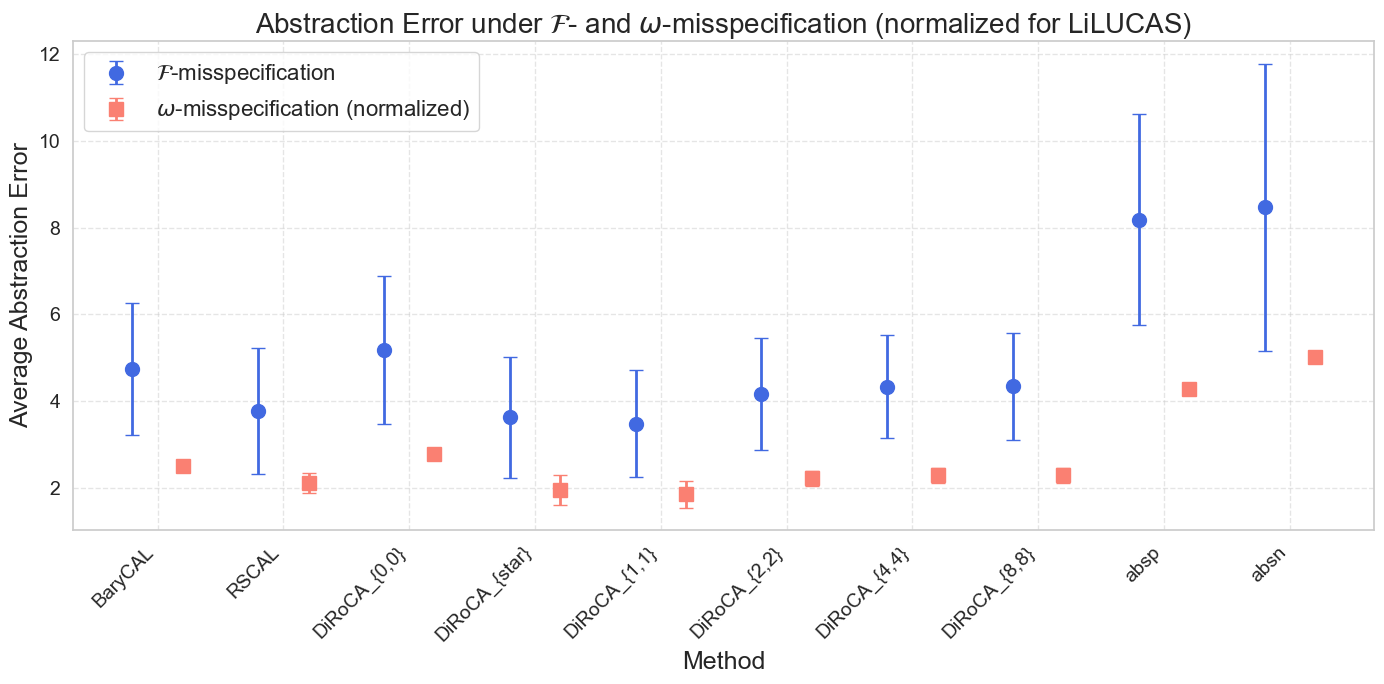

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Method names
methods = [
    "BaryCAL", "RSCAL", "DiRoCA_{0,0}", "DiRoCA_{star}", 
    "DiRoCA_{1,1}", "DiRoCA_{2,2}", "DiRoCA_{4,4}", "DiRoCA_{8,8}", 
    "absp", "absn"
]

# Mean values
lilucas_f_miss_mean = np.array([4.73, 3.78, 4.79, 3.73, 3.98, 4.49, 4.85, 4.86, 8.01, 5.38])
lilucas_omega_miss_mean = np.array([996.24, 656.56, 1031.64, 641.55, 702.88, 927.98, 1067.35, 1067.35, 1798.08, 1124.75])
ebm_f_miss_mean = np.array([4.74, 3.77, 5.57, 3.53, 2.97, 3.82, 3.82, 3.82, 8.36, 11.56])
ebm_omega_miss_mean = np.array([4.01, 3.56, 4.51, 3.28, 3.00, 3.51, 3.51, 3.51, 6.75, 8.91])

# Std values extracted correctly (printed error was mean ± 1.96*std)
lilucas_f_miss_std = np.array([1.29, 1.93, 1.15, 1.83, 1.85, 1.32, 0.94, 1.06, 1.22, 1.50]) / 1.96
lilucas_omega_miss_std = np.array([26.76, 20.48, 22.20, 19.81, 9.58, 11.75, 16.55, 16.55, 29.29, 14.65]) / 1.96
ebm_f_miss_std = np.array([4.69, 3.75, 5.52, 3.64, 2.99, 3.75, 3.75, 3.75, 8.28, 11.48]) / 1.96
ebm_omega_miss_std = np.array([0.45, 0.87, 0.29, 1.33, 1.18, 0.63, 0.63, 0.63, 0.34, 0.12]) / 1.96

# Normalize LiLUCAS omega values
lilucas_omega_miss_mean_normalized = lilucas_omega_miss_mean / np.mean(lilucas_omega_miss_mean)
lilucas_omega_miss_std_normalized = lilucas_omega_miss_std / np.mean(lilucas_omega_miss_mean)

# Keep EBM omega as is

# Compute averages
f_miss_mean = (lilucas_f_miss_mean + ebm_f_miss_mean) / 2
omega_miss_mean = (lilucas_omega_miss_mean_normalized + ebm_omega_miss_mean) / 2

f_miss_std = (lilucas_f_miss_std + ebm_f_miss_std) / 2
omega_miss_std = (lilucas_omega_miss_std_normalized + ebm_omega_miss_std) / 2

# Set bar positions
x_f = np.arange(len(methods)) * 2.5
x_omega = x_f + 1

import matplotlib.pyplot as plt
import numpy as np

# ... (your data setup code here) ...

fig, ax = plt.subplots(figsize=(14, 7))

# Custom colors and marker sizes
color_f = "royalblue"
color_omega = "salmon"
marker_f = "o"
marker_omega = "s"
ms_f = 10
ms_omega = 10

# Plot error bars
f1 = ax.errorbar(
    x_f, f_miss_mean, yerr=f_miss_std, fmt=marker_f, 
    color=color_f, label='$\\mathcal{F}$-misspecification', 
    capsize=5, markersize=ms_f, elinewidth=2, linewidth=2
)
f2 = ax.errorbar(
    x_omega, omega_miss_mean, yerr=omega_miss_std, fmt=marker_omega, 
    color=color_omega, label='$\\omega$-misspecification (normalized)', 
    capsize=5, markersize=ms_omega, elinewidth=2, linewidth=2
)

# Set x-ticks and labels
ax.set_xticks((x_f + x_omega) / 2)
ax.set_xticklabels(methods, rotation=45, ha="right", fontsize=16)

# Axis labels and title
ax.set_ylabel("Average Abstraction Error", fontsize=18)
ax.set_title("Abstraction Error under $\\mathcal{F}$- and $\\omega$-misspecification (normalized for LiLUCAS)", fontsize=20)
ax.set_xlabel("Method", fontsize=18)

# Increase tick label size
ax.tick_params(axis='both', which='major', labelsize=14)

# Add legend with larger font
ax.legend(fontsize=16)

# Add grid
ax.grid(True, linestyle='--', alpha=0.5)

# Optionally, annotate each method with its name above the points
for i, method in enumerate(methods):
    ax.annotate(method, ((x_f[i] + x_omega[i]) / 2, 0.95*ax.get_ylim()[0]), 
                ha='center', va='top', fontsize=13, rotation=45, color='gray')

plt.tight_layout()
plt.show()
